In [1]:
import json, os, sys, math, time, random

import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
# if loading MFCCs, ravel into 1-d array first
with open('msd-data/features.json', 'r') as f:
    all_features = json.load(f)

In [3]:
# Computes approximate sinusoity between the straight line from source to target and the actual path
# https://en.wikipedia.org/wiki/Sinuosity
def sinusoity(straight_line_distance: float, path: list[str], source: str, dest: str, distance_function):
    total_distance = 0
    path = [source, *path, dest]

    for i in range(len(path) - 1):
        start_feats = all_features[path[i]]
        end_feats = all_features[path[i+1]]
        
        total_distance += distance_function(start_feats, end_feats)
    
    return total_distance / straight_line_distance

# Computes the RMS deviation for a path, given the line defined the the source and destination songs
# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Vector_formulation
def rms_deviation(path: list[str], source: str, dest: str, distance_function, norm: int):
    start_feats = all_features[source]
    dest_feats = all_features[dest]

    if type(start_feats) == dict and type(dest_feats) == dict:
        start_feats = json_features_to_np(start_feats)
        dest_feats = json_features_to_np(dest_feats)
    
    # unit vector of the line x from start_feats to dest_feats
    n = (dest_feats - start_feats) / distance_function(n)

    square_deviation = 0
    for id in path:
        p_feats = all_features[id]
        if type(p_feats) == dict:
            p_feats = json_features_to_np(p_feats)
        
        p_minus_a = p_feats - start_feats
        t2 = np.dot(p_minus_a, n) * n # corresponds to ((p - a) . n) * n

        square_deviation += np.linalg.norm(p_minus_a - t2, ord=norm) ** 2

    return (square_deviation / len(path)) ** 0.5

In [65]:
def scatter_plot_results(RESULTS: str, distance_function, params: str):
    result_set = {}

    for result in os.listdir(RESULTS):
        with open(f'{RESULTS}/{result}') as f:
            res_data = json.load(f)
            if res_data['PATH']:
                result_set[result.strip('.json')] = res_data

    found, not_found, other = [], [], []

    for result in result_set.values():
        straight_line_distance = distance_function(result['SOURCE_FEATS'], result['TARGET_FEATS'])
        sins = sinusoity(straight_line_distance, result['PATH'], result['meta']['SOURCE_ID'], result['meta']['TARGET_ID'], distance_function)

        # if result['meta']['FOUND']:
        #     found.append([straight_line_distance, sins])
        # else:
        #     not_found.append([straight_line_distance, sins])

        if len(result['PATH']) == 1:
            other.append([straight_line_distance, sins])
        else:
            fits_line = True
            src_feats, dst_feats = result['SOURCE_FEATS'], result['TARGET_FEATS']
            distances = [(distance_function(all_features[p], src_feats), distance_function(all_features[p], dst_feats)) for p in result['PATH']]

            for i, (d_src, d_dst) in enumerate(distances[:-1]):
                o_d_src, o_d_dst = distances[i+1]

                if d_src > o_d_src or d_dst < o_d_dst:
                    fits_line = False
                    break
            
            if fits_line:
                found.append([straight_line_distance, sins])
            else:
                not_found.append([straight_line_distance, sins])

    found = np.array(found)
    not_found = np.array(not_found)
    other = np.array(other)

    # Filter outliers in terms of sinusoity
    std_range = 4

    found_sinusoity_std = np.std(found[:, 1])
    found_sinusoity_mean = np.mean(found[:, 1])
    found = found[abs(found[:, 1] - found_sinusoity_mean) < std_range * found_sinusoity_std]

    not_found_sinusoity_std = np.std(not_found[:, 1])
    not_found_sinusoity_mean = np.mean(not_found[:, 1])
    not_found = not_found[abs(not_found[:, 1] - not_found_sinusoity_mean) < std_range * not_found_sinusoity_std]

    other_sinusoity_std = np.std(other[:, 1])
    other_sinusoity_mean = np.mean(other[:, 1])
    other = other[abs(other[:, 1] - other_sinusoity_mean) < std_range * other_sinusoity_std]

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(colors='white', which='both')

    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.set_xlabel('Straight-Line Distance')
    ax.set_ylabel('Path Sinusoity')
    ax.set_title(f'Sinusoity-Distance Scatter Plot: {params}', color='white')

    found_color = '#eeee00'
    not_found_color = '#660066'
    other_color = '#00de00'

    ax.scatter(found[:, 0], found[:, 1], c=[found_color for _ in found], label='Fits Gradient')
    ax.scatter(not_found[:, 0], not_found[:, 1], c=[not_found_color for _ in not_found], label="Doesn't fit")
    # ax.scatter(other[:, 0], other[:, 1], c=[other_color for _ in other], label='Singleton')
    ax.legend()

    n_found, n_not_found = len(found), len(not_found)

    ax.annotate(f'Proportion fits: {(n_found / (n_found + n_not_found)):.3f} ({n_found} fits / {n_not_found} doesn\'t fit)' + \
                f'\nSingleton paths: {len(other)}\nFit avg. sinusoity: {np.mean(found[:, 1]):.3f}\nNo fit avg. sinusoity: {np.mean(not_found[:, 1]):.3}',
                xy=(0.24, 0.84), xycoords='subfigure fraction')


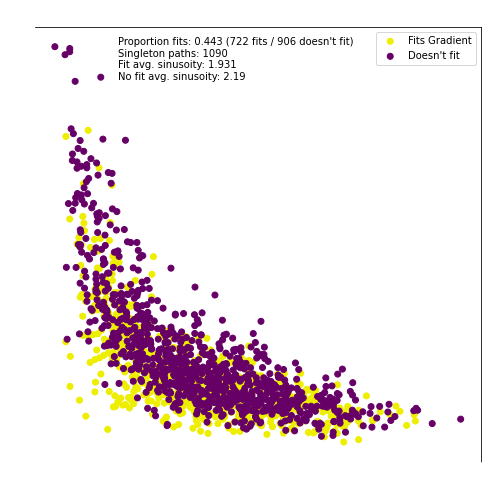

In [67]:
scatter_plot_results('msd-results/results-n=10-d=1000-l=1', feature_distance_l1, 'n=10, d=1000, l=1')

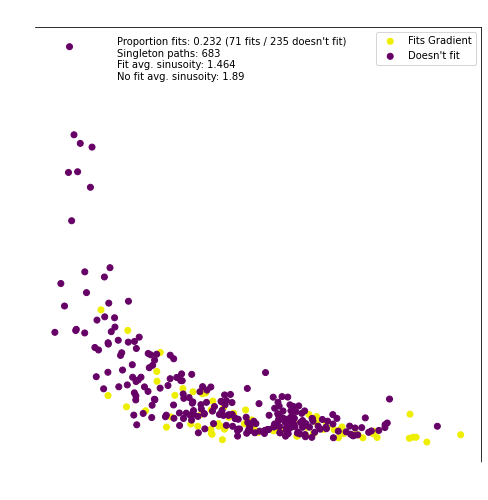

In [68]:
scatter_plot_results('msd-results/results-n=10-d=1000-l=2', feature_distance_l2, 'n=10, d=1000, l=2')

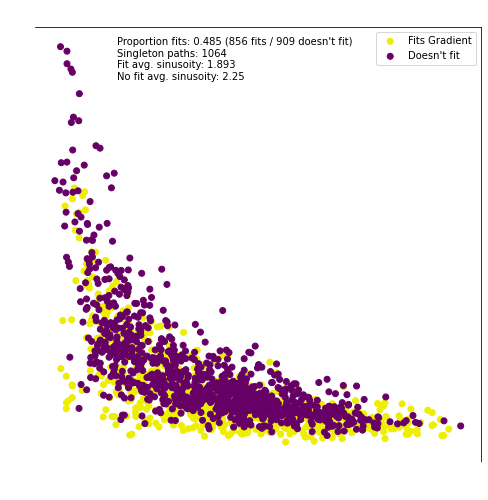

In [69]:
scatter_plot_results('msd-results/results-n=25-d=1000-l=1', feature_distance_l1, 'n=25, d=1000, l=1')

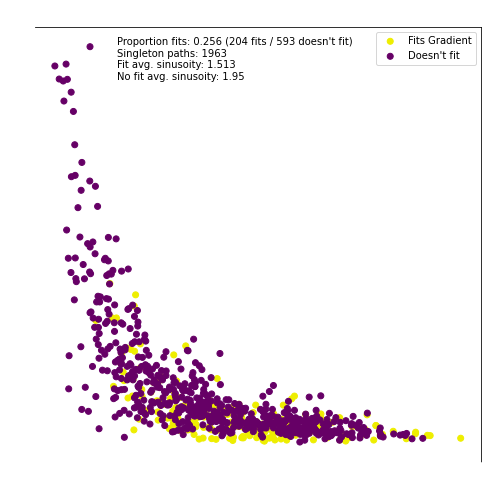

In [70]:
scatter_plot_results('msd-results/results-n=25-d=1000-l=2', feature_distance_l2, 'n=25, d=1000, l=2')

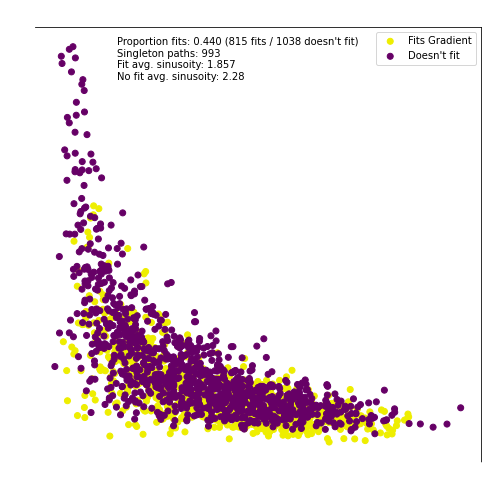

In [71]:
scatter_plot_results('msd-results/results-n=40-d=1000-l=1', feature_distance_l1, 'n=40, d=1000, l=1')

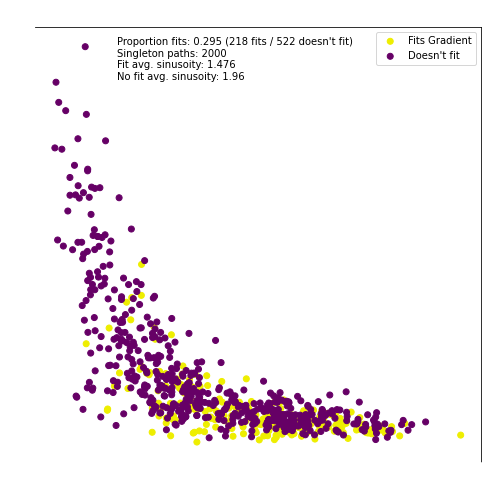

In [72]:
scatter_plot_results('msd-results/results-n=40-d=1000-l=2', feature_distance_l2, 'n=40, d=1000, l=2')

In [1]:
import numpy as np

In [2]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[7, 8, 9], [10, 11, 12]])

In [16]:
np.sqrt(np.sum(np.power(a - b, 2)))

14.696938456699069